$\Delta \epsilon/\epsilon_w$ [[0.2 0. ]]
[RLC_sensor] Initialized with:
  Lc = 8.000000000000001e-07 H
  Cp = 1e-12 F
  Self-capacitance = 0 F
  Total capacitance (C_total) = 1e-12 F
  RL = 40 Ω
  Rc = 100000000.0 Ω
  Z0 = 50 Ω
  R0 = 50000000.0 Ω
  g0 = 2e-08 S
  eps_w = 1 eV
  Resonant frequency (f0) = 1.779e+08 Hz
  Resonant period (T0) = 5.620e-09 s
  Capacitance noise model: OU_noise
Conductance per state (g/g0) :  [0.63473959 0.78644773 0.63473959 0.78644773 0.63473959 0.78644773
 0.63473959 0.78644773 0.63473959 0.78644773]


Sensor 0: 100%|██████████| 10/10 [01:19<00:00,  7.91s/it]


[RLC_sensor] Initialized with:
  Lc = 8.000000000000001e-07 H
  Cp = 1e-12 F
  Self-capacitance = 0 F
  Total capacitance (C_total) = 1e-12 F
  RL = 40 Ω
  Rc = 100000000.0 Ω
  Z0 = 50 Ω
  R0 = 50000000.0 Ω
  g0 = 2e-08 S
  eps_w = 1 eV
  Resonant frequency (f0) = 1.779e+08 Hz
  Resonant period (T0) = 5.620e-09 s
  Capacitance noise model: OU_noise
Conductance per state (g/g0) :  [0.63473959 0.78644773 0.63473959 0.78644773 0.63473959 0.78644773
 0.63473959 0.78644773 0.63473959 0.78644773]


Sensor 0: 100%|██████████| 10/10 [01:20<00:00,  8.02s/it]


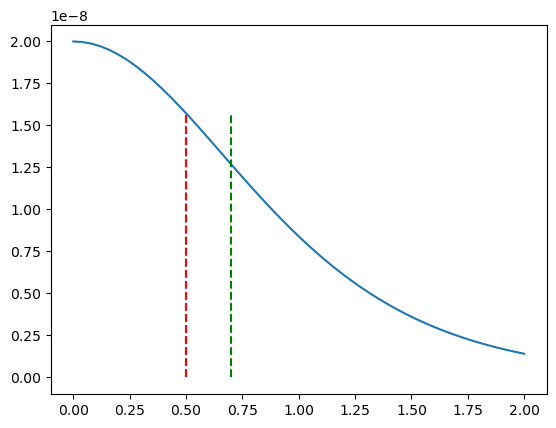

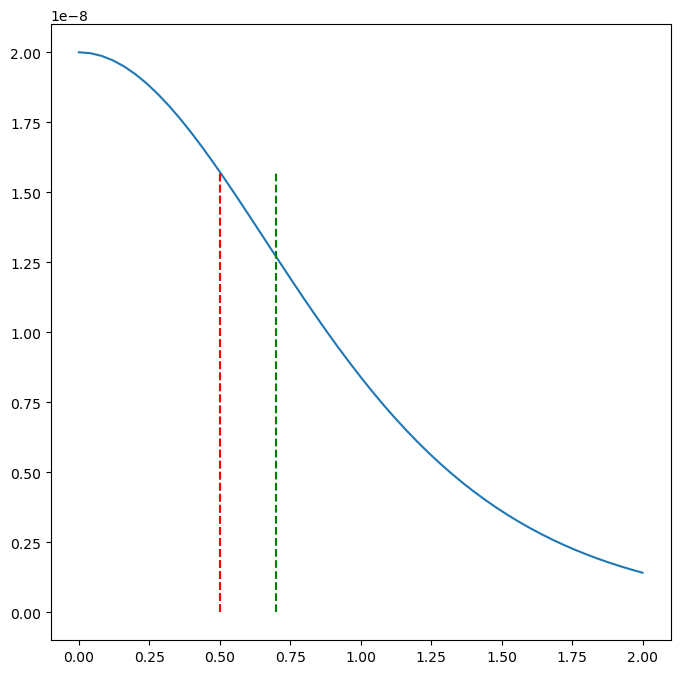

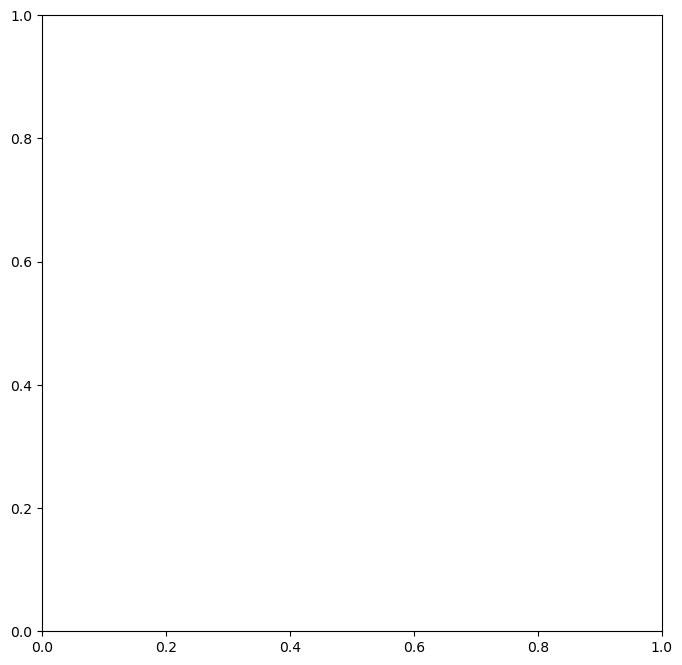

In [ ]:
# src/readout_simulator/main.py
import sys
import os
import importlib
# Add the src directory to the Python path
sys.path.append(os.path.abspath('src'))



import numpy as np
import simulator as sm
import sensor_backend as sb
from noise_models import OverFNoise
import quantum_dot_system as qds

from noise import OU_noise # Added
importlib.reload(sm)
importlib.reload(sb)
importlib.reload(qds)




# DEFINITION OF QUANTUM DOT SYSTEM
deps_eps0 = 0.5 # shift in sensor detuning in the units of width eps_w
Cdd_2dot = np.array([[1, 0], [0, 1]])   # NOTE: Ndots x Ndots, diagonal->no cross-capacitance
Cds_2dot = np.array([[1], [0]])*deps_eps0   # NOTE: Nsensors x Ndots

dot_system = qds.QuantumDotSystem(Cdd_2dot, Cds_2dot)  #geometry



# --- Simulation Parameters ---
params = { 
    'SNR_white': 100,  #NOTE: better tuning is needed
    'eps0': 0.5  # Nominal position on the Coulomb peak in the units width
}

nT_end = 2000 #periods of oscillation
charge_states = [np.array([1, 0]), np.array([0, 1])]*5


params_resonator = {
    'Lc': 800*1e-9,  # Inductance of the resonator
    'Cp': 1e-12,  # Capacitance of the resonator
    'RL': 40,  # Resistance of the resonator
    'Rc': 100e6,  # Coupling resistance
    'Z0': 50      
    }
params_coulomb_peak = {
    "g0" : 1/50/1e6,   # Max conductance of coulomb peak RELATIVE UNITS
    "eps0" : 0.5,    # in relative to eps_width
    "eps_width" : 1, # V
}

eps_noise = OverFNoise(
                n_fluctuators=1, s1=10 * 1e-99, sigma_couplings=1e-99,
                ommax=1 / 1, ommin=1 / 5,
                dt=1
            )
c_noise = OU_noise(sigma=1e-99, gamma=1e7)
sensors = [sb.RLC_sensor(params_resonator, params_coulomb_peak, c_noise, eps_noise)]

# --- Inductor Noise Parameters ---
C_noise_model = OU_noise(sigma=1e-99, gamma=1e7)
simulator = sm.ReadoutSimulator(
    dot_system=dot_system, 
    sensors = sensors
)
simulator.run_simulation(charge_states, nT_end, params)
IQ_clean, t = simulator.get_int_IQ()


# --- Noisy simulator ---
c_noise = OU_noise(sigma=1e-13, gamma=1e5)
sensors = [sb.RLC_sensor(params_resonator, params_coulomb_peak, c_noise, eps_noise)]

simulator2 = sm.ReadoutSimulator(
    dot_system=dot_system, 
    sensors=sensors
)

simulator2.run_simulation(charge_states, nT_end, params)
IQ_noisy, t2 = simulator2.get_int_IQ()



In [25]:
IQ_clean[0]["I"].shape

(50,)

Mean I for clean IQ: [ 2.48074243e-05  1.79704042e-05 -5.26139348e-06 ...  4.56751589e-07
  4.54863169e-07  4.54061109e-07]
Mean Q for clean IQ: [-0.50001839 -0.50000706 -0.50000557 ... -0.49999905 -0.49999904
 -0.49999904]


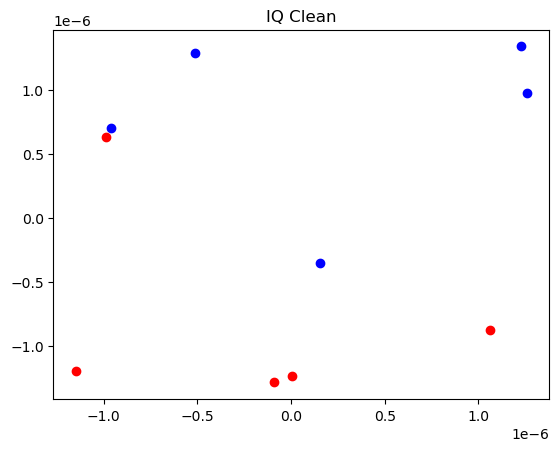

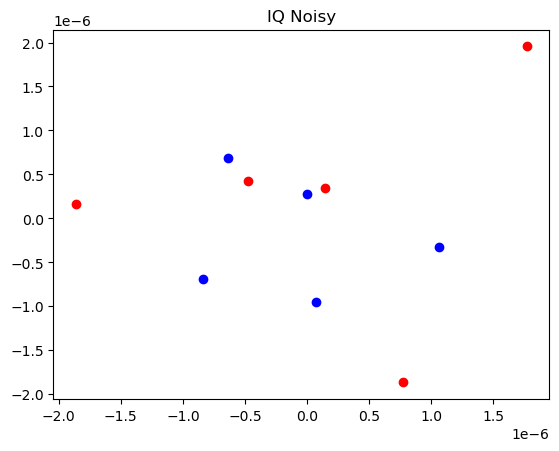

In [20]:
import matplotlib.pyplot as plt


Ic_mean = np.mean([IQ["I"] for IQ in IQ_clean], axis=0)
Qc_mean = np.mean([IQ["Q"] for IQ in IQ_clean], axis=0)
print(f"Mean I for clean IQ: {Ic_mean}")
print(f"Mean Q for clean IQ: {Qc_mean}")
Ic_noisy_mean = np.mean([IQ["I"] for IQ in IQ_noisy], axis=0)
Qc_noisy_mean = np.mean([IQ["Q"] for IQ in IQ_noisy], axis=0    )

plt.title("IQ Clean")
for n, IQ in enumerate(IQ_clean):
    if n % 2 == 0:
        plt.scatter(IQ_clean[n]["I"][-1] - Ic_mean[-1], IQ_clean[n]["Q"][-1] - Qc_mean[-1], label='Clean IQ', color='blue')
    else:
        plt.scatter(IQ_clean[n]["I"][-1] - Ic_mean[-1], IQ_clean[n]["Q"][-1] - Qc_mean[-1], label='Clean IQ', color='red')

plt.figure()
plt.title("IQ Noisy")
for n, IQ in enumerate(IQ_noisy):
    if n % 2 == 0:
        plt.scatter(IQ_noisy[n]["I"][-1] - Ic_noisy_mean[-1], IQ_noisy[n]["Q"][-1] - Qc_noisy_mean[-1], label='Noisy IQ', color='blue')
    else:
        plt.scatter(IQ_noisy[n]["I"][-1] - Ic_noisy_mean[-1], IQ_noisy[n]["Q"][-1] - Qc_noisy_mean[-1], label='Noisy IQ', color='red')




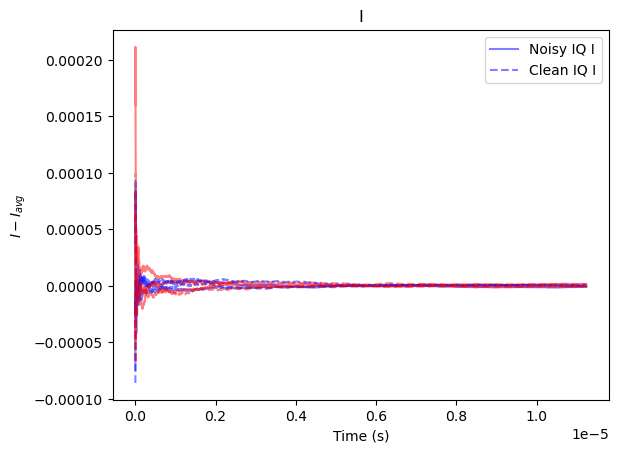

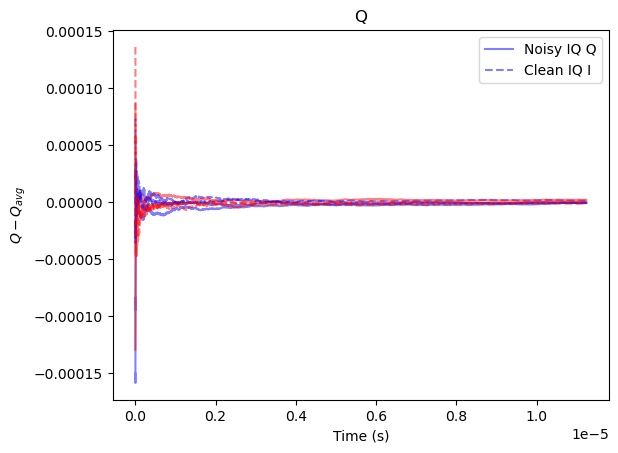

In [21]:
import matplotlib.pyplot as plt

Nplot = 4
plt.figure()
colors = ['blue', 'red' ]
for k in range(Nplot):
    plt.plot(t2, IQ_noisy[k]["I"] - Ic_noisy_mean, color=colors[k%2], alpha=0.5
                   , label='Noisy IQ I' if k == 0 else "") 
    plt.plot(t2, IQ_clean[k]["I"] - Ic_mean, color=colors[k%2], linestyle='--', alpha=0.5,label='Clean IQ I' if k == 0 else "") 
plt.title("I")
plt.xlabel("Time (s)")
plt.ylabel("$I - I_{avg}$")
plt.legend()
#plt.ylim(-1e-5,1e-5)

plt.figure()
for k in range(Nplot):
    plt.plot(t2, IQ_noisy[k]["Q"] - Qc_noisy_mean, color=colors[k%2], alpha=0.5
                   , label='Noisy IQ Q' if k == 0 else "") 
    plt.plot(t2, IQ_clean[k]["Q"] - Qc_mean, color=colors[k%2], linestyle='--', alpha=0.5, label='Clean IQ I' if k == 0 else "") 
plt.title("Q")
plt.xlabel("Time (s)")
plt.ylabel("$Q - Q_{avg}$")
plt.legend()
#plt.ylim(-1e-5,1e-5)





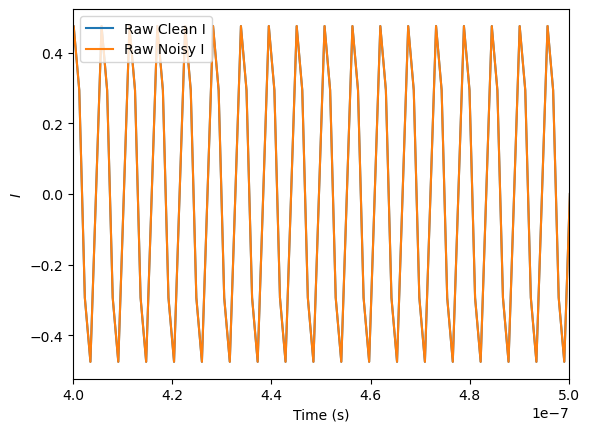

In [22]:
# plot raw signal
plt.figure()
raw_clean = simulator.get_raw_signal()
raw_noisy = simulator2.get_raw_signal()

plt.plot(t2, raw_noisy[1][0], label='Raw Clean I')
plt.plot(t2, raw_noisy[0][0], label='Raw Noisy I')
plt.xlabel("Time (s)")
plt.ylabel("$I$")
plt.xlim(0.4*1e-6,0.5*1e-6)
plt.legend()


ValueError: x and y must have same first dimension, but have shapes (2000,) and (100,)

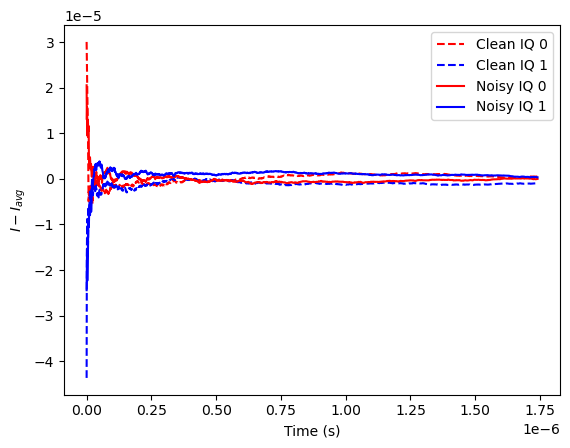

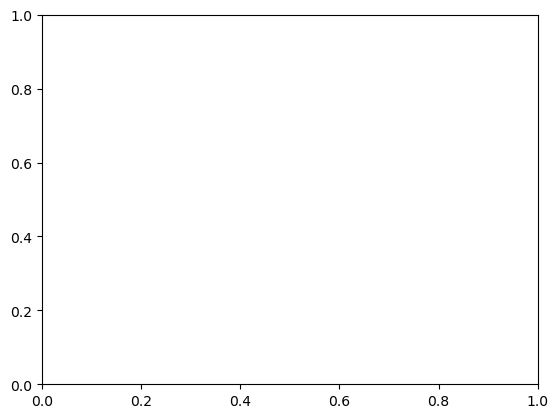

In [61]:
import matplotlib.pyplot as plt

IQ_mean = np.mean(IQ_clean, axis=0)
IQ2_mean = np.mean(IQ_noisy, axis=0)


plt.plot(t2, IQ_clean[0][0] - IQ_mean[0], color = "r", linestyle='--', label='Clean IQ 0')
plt.plot(t2,IQ_clean[1][0] - IQ_mean[0], color = "b", linestyle='--', label='Clean IQ 1')
plt.plot(t2,IQ_noisy[0][0] - IQ2_mean[0], color ="r" , label='Noisy IQ 0')
plt.plot(IQ_noisy[1][0] - IQ2_mean[0] , color ="b", label='Noisy IQ 1')
plt.xlabel('Time (s)')
plt.ylabel('$I - I_{avg}$')
plt.legend()


plt.figure()
plt.plot(t2,IQ[0][1], color = "r", linestyle='--', label='Clean IQ 0' )
plt.plot(t2,IQ2[0][1], color ="r" ,   label='Noisy IQ 0')
plt.plot(t2,IQ[1][1], color = "b", linestyle='--', label='Clean IQ 1')
plt.plot(t2,IQ2[1][1], color ="b", label='Noisy IQ 1')
plt.xlabel('Time (s)')
plt.ylabel('$Q - Q_{avg}$')


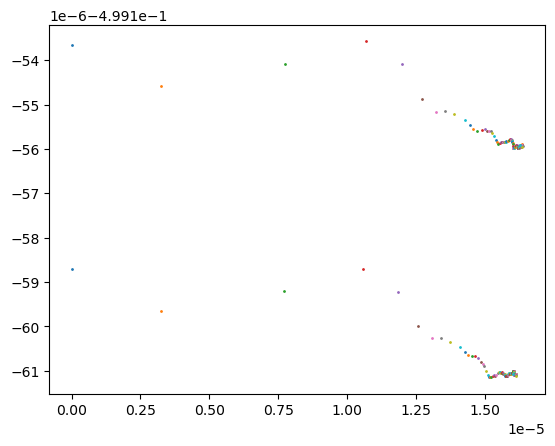

In [17]:
import matplotlib.pyplot as plt
plt.plot(IQ[:, 0], IQ[:, 1], 'o', markersize=1, label='IQ Data')

In [14]:
Cdd_inv

array([[1.01209048e+17, 9.16536661e+15, 5.85023401e+15],
       [9.16536661e+15, 8.56084243e+16, 1.20904836e+16],
       [5.85023401e+15, 1.20904836e+16, 9.28237129e+16]])

In [13]:
Cds_3dot

array([[-1.0e-18,  1.0e-19],
       [ 1.0e-19, -1.2e-18],
       [-2.0e-19,  3.0e-19]])